In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
output = model.invoke("hi")
print(output.content)

Hi there! How can I help you today?


In [2]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

c:\Users\SRJ\SRJ\Work\agentic_ai\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384

In [3]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("C:\\Users\\SRJ\\SRJ\\Work\\agentic_ai\\Project2\\data\\List-of-Prime-Ministers-in-India.pdf")
docs = loader.load()
docs

[Document(metadata={'producer': 'GPL Ghostscript 9.21', 'creator': 'Microsoft® Word 2013', 'creationdate': '2017-09-30T07:59:58+02:00', 'moddate': '2017-10-27T05:32:04-04:00', 'spdf': '1132', 'author': '2', 'enhanced': 'By PDF Enhancer 3.8.10571/Unix', 'source': 'C:\\Users\\SRJ\\SRJ\\Work\\agentic_ai\\Project2\\data\\List-of-Prime-Ministers-in-India.pdf', 'total_pages': 5, 'page': 0, 'page_label': '1'}, page_content="1 | P a g e  \n \nList of Prime Ministers in India - for SSC \n& Bank Exams \nExams like SSC CGL, SSC CPO, IBPS PO, IBPS SO, LIC AAO focus a lot on the \nsection of General Awareness. You will find a lot of questions based on Polity and \nespecially relevant Prime Ministers of India in these papers.  To make your \npreparation for these exams easy, we are providing you with a list of all Prime Ministers \nin India. Read the entire article to know about all the Prime Ministers till date, their \ntenures and major facts about Prime Ministerial Elections in India. \nBefore we

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)
new_docs = text_splitter.split_documents(documents=docs)

In [5]:
from langchain_community.vectorstores import Chroma

db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 10})
retriever.invoke("pm of india")

[Document(metadata={'author': '2', 'creationdate': '2017-09-30T07:59:58+02:00', 'creator': 'Microsoft® Word 2013', 'enhanced': 'By PDF Enhancer 3.8.10571/Unix', 'moddate': '2017-10-27T05:32:04-04:00', 'page': 2, 'page_label': '3', 'producer': 'GPL Ghostscript 9.21', 'source': 'C:\\Users\\SRJ\\SRJ\\Work\\agentic_ai\\Project2\\data\\List-of-Prime-Ministers-in-India.pdf', 'spdf': '1132', 'total_pages': 5}, page_content='o He is the first Prime Minister of India. \no Also, he brought the reform of the Ancient Hindu Civil Code. \n\uf0b7 Gulzarilal Nanda'),
 Document(metadata={'author': '2', 'creationdate': '2017-09-30T07:59:58+02:00', 'creator': 'Microsoft® Word 2013', 'enhanced': 'By PDF Enhancer 3.8.10571/Unix', 'moddate': '2017-10-27T05:32:04-04:00', 'page': 0, 'page_label': '1', 'producer': 'GPL Ghostscript 9.21', 'source': 'C:\\Users\\SRJ\\SRJ\\Work\\agentic_ai\\Project2\\data\\List-of-Prime-Ministers-in-India.pdf', 'spdf': '1132', 'total_pages': 5}, page_content='of Prime Ministers in

In [6]:
from pydantic import BaseModel, Field

class Topic(BaseModel):
    Topic:str = Field(description="The topic of the question")
    Reasoning:str = Field(description="The reasoning behind topic selection")

In [7]:
from langchain.output_parsers import PydanticOutputParser

parser = PydanticOutputParser(pydantic_object=Topic)

In [8]:
import operator
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [9]:
from langchain import PromptTemplate

def function_1(state: AgentState):
    question = state["messages"][-1]
    print("Question", question)

    template = """
    Your task is to classify the user query into one of the following categories: [Prime Ministers of India, Current Affairs, Not related].
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """

    prompt = PromptTemplate(
        template = template,
        input_variable = ["question"],
        partial_variables = {"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser

    response = chain.invoke({"question" : question})
    print("Parsed response:", response)
    return {"messages" : [response.Topic]}

In [10]:
def router(state: AgentState):
    print("->ROUTER->")

    last_message = state["messages"][-1]
    print("Last message:", last_message)

    if "ministers" in last_message.lower():
        return "RAG Call"
    elif "current" in last_message.lower():
        return "Tool Call"
    else:
        return "LLM Call"

In [11]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


def function_2(state: AgentState):
    print("->Function_2->")

    question = state["messages"][0]

    prompt = PromptTemplate(
        template="""
        You are a helpful assistant. Answer the question based on the context provided.
        
        Context:
        {context}
        
        Question: {question}
        """,
        input_variables=["context", "question"]
    )

    rag_chain = (
        {"context" : retriever | format_docs, "question" : RunnablePassthrough()}
        |prompt
        |model
        |StrOutputParser()
    )

    result = rag_chain.invoke(question)
    print("RAG response:", result, sep=" | ")
    return {"messages" : [result]}

In [12]:
from langchain_community.tools import TavilySearchResults
tool = TavilySearchResults(tavily_api_key="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")

def function_3(state: AgentState):
    print("->Tool Call->")
    question = state["messages"][0]

    query = "Answer the question : " + question
    response = tool.invoke(query)
    print("Tool response:", response[0]["content"], sep=" | ")
    return {"messages" : [response[0]["content"]]}

In [13]:
def function_4(state: AgentState):
    print("->LLM Call->")
    question = state["messages"][0]

    query = "Answer the question : " + question
    respose = model.invoke(query)
    print("LLM response:", response.content, sep=" | ")
    return {"messages" : [respose.content]}

In [14]:
def validator(state: AgentState):
    print("->Validator Call->")
    question = state["messages"][0]
    answer = state["messages"][-1]
    query = f"""
    Validate if the response for given query is precise and can be shown as output or it needs to be checked again : Question -> {question}, Answer -> {answer}.
    If it needs to be checked again. 
    According to your understanding respond in ['Restart Call' or 'End']
    """
    response = model.invoke(query)
    print("Validator response:", response.content, sep=" | ")
    return {"messages" : [response.content]}

In [15]:
def checker(state: AgentState):
    print("->Checker->")
    last_message = state["messages"][-1]
    
    if "restart" in last_message.lower():
        return "Restart"
    else:
        return "No Restart"

In [16]:
def restarter(state: AgentState):
    print("->Restarter Call->")
    question = state["messages"][0]
    state["messages"] = []

    query = f"""
    Please modify the language of the given question in such a way that the llm can understand properly if the question
    should go for RAG call or Tool call or LLM call. Question: {question}. Respond with just the question
    in the following format -> 'Question' : <modified_question>
    """
    response = model.invoke(query)
    print('Restarter response:', question, response.content, sep=" | ")
    return {"messages" : [response.content]}


In [17]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)
workflow.add_node("Supervisor", function_1)
workflow.add_node("RAG", function_2)
workflow.add_node("Tool", function_3)
workflow.add_node("LLM", function_4)
workflow.add_node("Validator", validator)
workflow.add_node("Restarter", restarter)

workflow.set_entry_point("Supervisor")

workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call":"RAG",
        "LLM Call":"LLM",
        "Tool Call":"Tool",
    }
)

workflow.add_edge("RAG", "Validator")
workflow.add_edge("LLM", "Validator")
workflow.add_edge("Tool", "Validator")

workflow.add_conditional_edges(
    "Validator",
    checker,
    {
        "Restart":"Restarter",
        "No Restart":END
    }
)

workflow.add_edge("Restarter", "Supervisor")

app = workflow.compile()

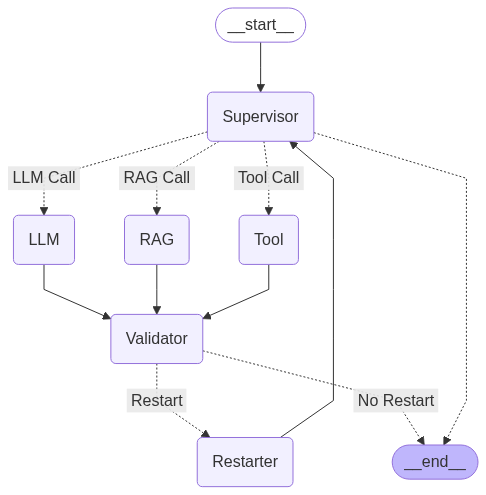

In [18]:
app

In [19]:
state = {"messages": ["Who is the fourth of India?"]}
res = app.invoke(state)
print(res)

Question Who is the fourth of India?
Parsed response: Topic='Prime Ministers of India' Reasoning="The query asks for the 'fourth of India', which, despite being vague, most plausibly refers to the fourth Prime Minister of India within the context of the provided categories. It is a common way to refer to a specific individual in a sequence of national leaders."
->ROUTER->
Last message: Prime Ministers of India
->Function_2->
RAG response: | Based on the chronological list of Prime Ministers provided:

1.  Jawaharlal Nehru
2.  Gulzarilal Nanda
3.  Lal Bahadur Shastri
4.  Gulzarilal Nanda

Therefore, the fourth Prime Minister listed is **Gulzarilal Nanda**.
->Validator Call->
Validator response: | Restart Call
->Checker->
->Restarter Call->
Restarter response: | Who is the fourth of India? | 'Question' : Who was the fourth Prime Minister of India?
Question 'Question' : Who was the fourth Prime Minister of India?
Parsed response: Topic='Prime Ministers of India' Reasoning="The user query 

KeyboardInterrupt: 